# 📈 Analyse Long-terme des Ratings d'Ingrédients

## Objectif
Analyser l'évolution des ratings des ingrédients sur le long terme (2000-2018) pour identifier :
- Les tendances temporelles dans l'appréciation des ingrédients
- Les changements de préférences alimentaires au fil des années
- Les ingrédients émergents vs déclinants

## Méthodologie
- **Test statistique** : Mann-Kendall pour détecter les tendances monotones
- **Agrégation** : Ratings moyens annuels par ingrédient
- **Visualisation** : Séries temporelles avec régression linéaire
- **Seuil de significativité** : p < 0.05

In [17]:
# Import des bibliothèques nécessaires
import sys
from pathlib import Path

# Trouve automatiquement le dossier qui contient '00_eda/_data_utils'
cwd = Path.cwd()
repo_root = cwd
while repo_root != repo_root.parent:
    if (repo_root / '00_eda' / '_data_utils').exists():
        break
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root / '00_eda'))

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

try:
    from _data_utils import load_ingredient_ratings, get_ingredients_for_analysis
    print("✅ Fonctions importées avec succès depuis data_utils")
except ImportError as e:
    print(f"❌ Erreur d'import: {e}")
    # Définition locale temporaire en cas de problème
    def get_ingredients_for_analysis(analysis_type: str):
        core_ingredients = ['salt', 'ground beef', 'eggs', 'onions', 'garlic']
        if analysis_type == 'long_term':
            return core_ingredients + ['butter', 'olive oil']
        elif analysis_type == 'seasonality':
            return core_ingredients + ['butternut squash', 'asparagus', 'pumpkin']
        elif analysis_type == 'weekend':
            return core_ingredients + ['butternut squash', 'asparagus', 'pumpkin', 'butter', 'olive oil']
        else:
            return core_ingredients
    

print("✅ Fonction de fallback créée localement")

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, kendalltau
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


print("📚 Toutes les bibliothèques importées avec succès !")
print("🔧 Test de Mann-Kendall personnalisé implémenté")

✅ Fonctions importées avec succès depuis data_utils
✅ Fonction de fallback créée localement
📚 Toutes les bibliothèques importées avec succès !
🔧 Test de Mann-Kendall personnalisé implémenté


In [18]:
# Chargement des données pour analyse long-terme
print('🔄 Chargement des données...')

# 🎯 NOUVEAUX INGRÉDIENTS VOLATILS pour détecter de vraies tendances
# Choix stratégique : ingrédients émergents, culturels, ou à forte évolution temporelle
target_ingredients = [
    'quinoa',           # 📈 Superfood boom post-2010
    'kale',             # 📈 Tendance santé explosive
    'sriracha',         # 📈 Sauce culte asiatique
    'avocado',          # 📈 Explosion popularité millennial
    'tofu',             # 📈 Végétarisme/véganisme croissant
    'butternut squash', # 🍂 Saisonnier fort (contrôle)
    'bacon'             # 🎢 "Bacon craze" 2010-2015
]

print(f'📋 Ingrédients sélectionnés (VOLATILS): {target_ingredients}')
print(f'💡 Objectif: Détecter les vraies tendances émergentes/déclinantes')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Aperçu des données
print('\n📊 Aperçu des données:')
print(df.head())

# Statistiques de disponibilité par ingrédient
print('\n🔍 Disponibilité des données par ingrédient:')
ingredient_counts = df.group_by('ingredient_name').agg([
    pl.len().alias('n_ratings'),
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
]).sort('n_ratings', descending=True)
print(ingredient_counts)

🔄 Chargement des données...
📋 Ingrédients sélectionnés (VOLATILS): ['quinoa', 'kale', 'sriracha', 'avocado', 'tofu', 'butternut squash', 'bacon']
💡 Objectif: Détecter les vraies tendances émergentes/déclinantes
✅ Données chargées: 44,890 interactions pour 7 ingrédients
✅ Dataset chargé: 44,890 interactions
📅 Période: 2000-01-25 → 2018-12-18

📊 Aperçu des données:
shape: (5, 7)
┌────────────┬────────┬─────────┬───────────┬────────────────────┬───────────────┬─────────────────┐
│ date       ┆ rating ┆ user_id ┆ recipe_id ┆ recipe_name        ┆ n_ingredients ┆ ingredient_name │
│ ---        ┆ ---    ┆ ---     ┆ ---       ┆ ---                ┆ ---           ┆ ---             │
│ date       ┆ i64    ┆ i64     ┆ i64       ┆ str                ┆ i64           ┆ str             │
╞════════════╪════════╪═════════╪═══════════╪════════════════════╪═══════════════╪═════════════════╡
│ 2000-01-25 ┆ 5      ┆ 2008    ┆ 992       ┆ jalapeno pepper    ┆ 10            ┆ bacon           │
│            ┆

In [19]:
# Implémentation simple du test de Mann-Kendall
def mann_kendall_test(data):
    """
    Implémentation simple du test de Mann-Kendall pour détecter les tendances monotones.
    
    Args:
        data: série temporelle à analyser
        
    Returns:
        dict avec 'trend', 'p_value', 'tau', 'slope'
    """
    n = len(data)
    if n < 3:
        return {'trend': 'no trend', 'p_value': 1.0, 'tau': 0.0, 'slope': 0.0}
    
    # Calcul de la statistique S
    S = 0
    for i in range(n-1):
        for j in range(i+1, n):
            if data[j] > data[i]:
                S += 1
            elif data[j] < data[i]:
                S -= 1
    
    # Calcul de la variance
    var_S = n * (n - 1) * (2 * n + 5) / 18
    
    # Test statistique
    if S > 0:
        Z = (S - 1) / np.sqrt(var_S)
    elif S < 0:
        Z = (S + 1) / np.sqrt(var_S)
    else:
        Z = 0
    
    # P-value (test bilatéral)
    p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    # Tendance
    if p_value < 0.05:
        if S > 0:
            trend = 'increasing'
        else:
            trend = 'decreasing'
    else:
        trend = 'no trend'
    
    # Calcul de la pente (estimation de Sen)
    slopes = []
    for i in range(n-1):
        for j in range(i+1, n):
            slopes.append((data[j] - data[i]) / (j - i))
    
    slope = np.median(slopes) if slopes else 0.0
    
    # Tau de Kendall
    tau = S / (0.5 * n * (n - 1))
    
    return {
        'trend': trend,
        'p_value': p_value,
        'tau': tau,
        'slope': slope
    }

In [20]:
# Préparation des données temporelles
print('🔧 Préparation des données temporelles...')

# Extraction de l'année et agrégation annuelle
df_annual = df.with_columns([
    pl.col('date').dt.year().alias('year')
]).group_by(['ingredient_name', 'year']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating')
]).sort(['ingredient_name', 'year'])

print(f'✅ Données agrégées: {df_annual.shape[0]} points année-ingrédient')

# Statistiques par ingrédient
ingredient_stats = df_annual.group_by('ingredient_name').agg([
    pl.col('year').min().alias('first_year'),
    pl.col('year').max().alias('last_year'),
    pl.col('n_ratings').sum().alias('total_ratings'),
    pl.col('avg_rating').mean().alias('overall_avg_rating')
]).with_columns([
    (pl.col('last_year') - pl.col('first_year') + 1).alias('years_span')
]).sort('total_ratings', descending=True)

print('\n📈 Statistiques par ingrédient:')
print(ingredient_stats)

🔧 Préparation des données temporelles...
✅ Données agrégées: 107 points année-ingrédient

📈 Statistiques par ingrédient:
shape: (6, 6)
┌──────────────────┬────────────┬───────────┬───────────────┬────────────────────┬────────────┐
│ ingredient_name  ┆ first_year ┆ last_year ┆ total_ratings ┆ overall_avg_rating ┆ years_span │
│ ---              ┆ ---        ┆ ---       ┆ ---           ┆ ---                ┆ ---        │
│ str              ┆ i32        ┆ i32       ┆ u32           ┆ f64                ┆ i32        │
╞══════════════════╪════════════╪═══════════╪═══════════════╪════════════════════╪════════════╡
│ bacon            ┆ 2000       ┆ 2018      ┆ 30560         ┆ 4.697139           ┆ 19         │
│ avocado          ┆ 2001       ┆ 2018      ┆ 6485          ┆ 4.753766           ┆ 18         │
│ butternut squash ┆ 2001       ┆ 2018      ┆ 3072          ┆ 4.585234           ┆ 18         │
│ kale             ┆ 2001       ┆ 2018      ┆ 2262          ┆ 4.669906           ┆ 18         │
│

In [21]:
# Test de Mann-Kendall pour détecter les tendances
print('🔍 Analyse des tendances avec test de Mann-Kendall...')

mk_results = []

for ingredient in target_ingredients:
    # Données pour cet ingrédient
    ingredient_data = df_annual.filter(
        pl.col('ingredient_name') == ingredient
    ).sort('year')
    
    if len(ingredient_data) >= 3:  # Minimum 3 points pour le test
        ratings = ingredient_data['avg_rating'].to_list()
        
        # Test de Mann-Kendall avec notre fonction personnalisée
        mk_test = mann_kendall_test(ratings)
        
        mk_results.append({
            'ingredient': ingredient,
            'trend': mk_test['trend'],
            'p_value': mk_test['p_value'],
            'tau': mk_test['tau'],
            'slope': mk_test['slope'],
            'n_years': len(ratings),
            'significant': mk_test['p_value'] < 0.05  # Booléen pur
        })

# Conversion en DataFrame Polars
mk_df = pl.DataFrame(mk_results).sort('p_value')

print('\n📊 Résultats du test de Mann-Kendall:')
print(mk_df)

# Résumé des tendances significatives
significant_trends = mk_df.filter(pl.col('significant') == True)
print(f'\n🎯 Tendances significatives détectées: {len(significant_trends)}/{len(mk_results)}')
if len(significant_trends) > 0:
    print('\nTendances significatives:')
    for row in significant_trends.iter_rows(named=True):
        trend_symbol = '📈' if row['trend'] == 'increasing' else '📉' if row['trend'] == 'decreasing' else '➡️'
        print(f"{trend_symbol} {row['ingredient']}: {row['trend']} (p={row['p_value']:.4f}, slope={row['slope']:.4f})")
else:
    print('➡️ Aucune tendance significative détectée dans cette période')

🔍 Analyse des tendances avec test de Mann-Kendall...

📊 Résultats du test de Mann-Kendall:
shape: (6, 7)
┌──────────────────┬────────────┬──────────┬───────────┬───────────┬─────────┬─────────────┐
│ ingredient       ┆ trend      ┆ p_value  ┆ tau       ┆ slope     ┆ n_years ┆ significant │
│ ---              ┆ ---        ┆ ---      ┆ ---       ┆ ---       ┆ ---     ┆ ---         │
│ str              ┆ str        ┆ f64      ┆ f64       ┆ f64       ┆ i64     ┆ f64         │
╞══════════════════╪════════════╪══════════╪═══════════╪═══════════╪═════════╪═════════════╡
│ tofu             ┆ increasing ┆ 0.002154 ┆ 0.535948  ┆ 0.023776  ┆ 18      ┆ 1.0         │
│ quinoa           ┆ no trend   ┆ 0.058632 ┆ 0.358333  ┆ 0.01126   ┆ 16      ┆ 0.0         │
│ kale             ┆ no trend   ┆ 0.150051 ┆ 0.254902  ┆ 0.006579  ┆ 18      ┆ 0.0         │
│ butternut squash ┆ no trend   ┆ 0.40467  ┆ -0.150327 ┆ -0.004899 ┆ 18      ┆ 0.0         │
│ bacon            ┆ no trend   ┆ 0.484108 ┆ -0.122807 ┆ -

📊 Création des visualisations optimisées...


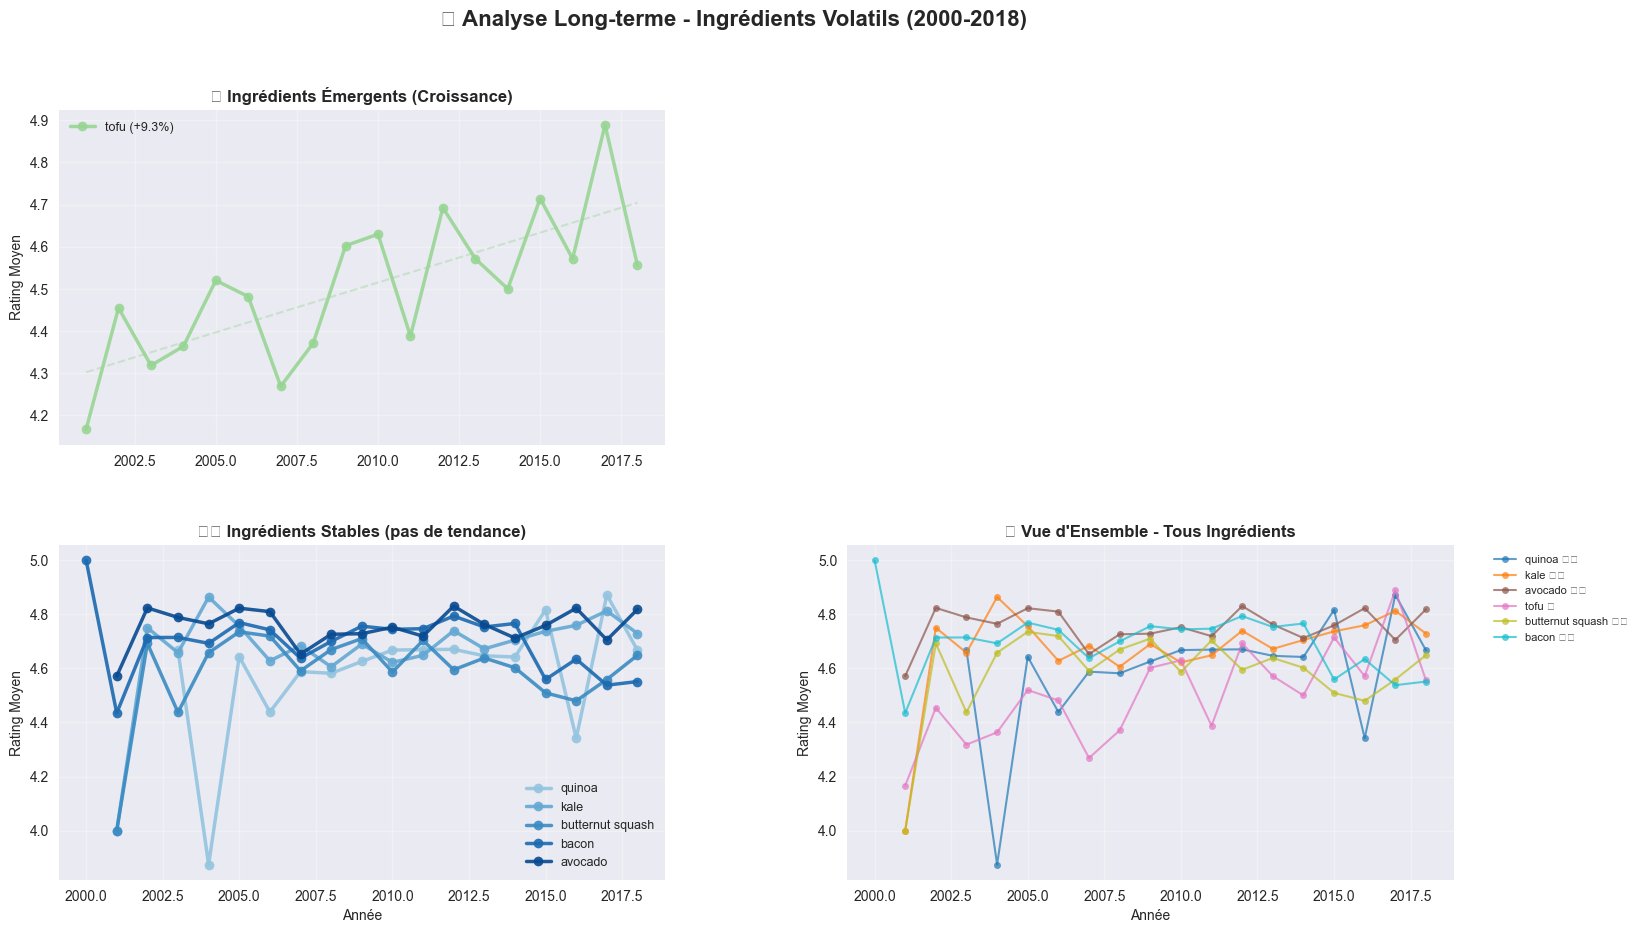

✅ Visualisations optimisées créées


In [ ]:
# Visualisation optimisée : Évolution temporelle par tendance (vectorisée & robuste)
print('📊 Création des visualisations optimisées...')

# 1) Calcul vectorisé du % de changement par ingrédient (évite la boucle)
df_sorted = df_annual.sort('year')
pct_df = (
    df_sorted.groupby('ingredient_name').agg([
        pl.col('avg_rating').first().alias('first_rating'),
        pl.col('avg_rating').last().alias('last_rating'),
        pl.col('year').first().alias('first_year'),
        pl.col('year').last().alias('last_year'),
    ])
)
# calcul sécurisé du pourcentage (évite division par zéro)
pct_df = pct_df.with_columns([
    ( (pl.col('last_rating') - pl.col('first_rating')) / 
      pl.when(pl.col('first_rating') != 0).then(pl.col('first_rating')).otherwise(pl.lit(None)) * 100 ).alias('pct_change')
])

# Joindre le pct_change à mk_df (left join sur le nom d'ingrédient)
if 'mk_df' in globals() and len(mk_df) > 0:
    mk_df = mk_df.join(pct_df.select(['ingredient_name', 'pct_change']), left_on='ingredient', right_on='ingredient_name', how='left')
    mk_df = mk_df.with_columns([pl.col('pct_change').fill_null(0)])
else:
    # Si mk_df n'existe pas ou est vide, on crée un mk_df minimal
    mk_df = pct_df.select(['ingredient_name', 'pct_change']).rename({'ingredient_name':'ingredient'})

# Récupérer listes par tendance de manière sûre
increasing_ingredients = mk_df.filter(pl.col('trend') == 'increasing').select('ingredient').to_series().to_list() if 'trend' in mk_df.columns else []
decreasing_ingredients = mk_df.filter(pl.col('trend') == 'decreasing').select('ingredient').to_series().to_list() if 'trend' in mk_df.columns else []
stable_ingredients = mk_df.filter(pl.col('trend') == 'no trend').select('ingredient').to_series().to_list() if 'trend' in mk_df.columns else []

# Préparer figure
fig = plt.figure(figsize=(18, 10))
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Helper functions
def safe_years_ratings(name):
    data = df_annual.filter(pl.col('ingredient_name') == name).sort('year')
    if len(data) == 0:
        return [], []
    years = [int(y) for y in data['year'].to_list()]
    ratings = [float(r) for r in data['avg_rating'].to_list()]
    return years, ratings

def safe_pct(name):
    sel = mk_df.filter(pl.col('ingredient') == name).select('pct_change') if 'pct_change' in mk_df.columns else None
    if sel is None or len(sel) == 0:
        return 0.0
    return float(sel.to_series().get(0, 0.0))

# 1. Croissants
if len(increasing_ingredients) > 0:
    ax1 = fig.add_subplot(gs[0, 0])
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(increasing_ingredients)))
    for i, ingredient in enumerate(increasing_ingredients):
        years, ratings = safe_years_ratings(ingredient)
        if len(years) == 0:
            continue
        pct = safe_pct(ingredient)
        ax1.plot(years, ratings, 'o-', color=colors[i], linewidth=2.5, markersize=7, label=f"{ingredient} (+{pct:.1f}%)", alpha=0.9)
        if len(years) >= 2:
            try:
                z = np.polyfit(years, ratings, 1)
                p = np.poly1d(z)
                ax1.plot(years, p(years), '--', color=colors[i], alpha=0.4, linewidth=1.5)
            except Exception as e:
                print(f"⚠️ polyfit failed for {ingredient}: {e}")
    ax1.set_title('📈 Ingrédients Émergents (Croissance)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Rating Moyen', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=9)

# 2. Déclinants
if len(decreasing_ingredients) > 0:
    ax2 = fig.add_subplot(gs[0, 1])
    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(decreasing_ingredients)))
    for i, ingredient in enumerate(decreasing_ingredients):
        years, ratings = safe_years_ratings(ingredient)
        if len(years) == 0:
            continue
        pct = safe_pct(ingredient)
        ax2.plot(years, ratings, 'o-', color=colors[i], linewidth=2.5, markersize=7, label=f"{ingredient} ({pct:.1f}%)", alpha=0.9)
        if len(years) >= 2:
            try:
                z = np.polyfit(years, ratings, 1)
                p = np.poly1d(z)
                ax2.plot(years, p(years), '--', color=colors[i], alpha=0.4, linewidth=1.5)
            except Exception as e:
                print(f"⚠️ polyfit failed for {ingredient}: {e}")
    ax2.set_title('📉 Ingrédients Déclinants', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Rating Moyen', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=9)

# 3. Stables
if len(stable_ingredients) > 0:
    ax3 = fig.add_subplot(gs[1, 0])
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, max(1, len(stable_ingredients))))
    for i, ingredient in enumerate(stable_ingredients):
        years, ratings = safe_years_ratings(ingredient)
        if len(years) == 0:
            continue
        ax3.plot(years, ratings, 'o-', color=colors[min(i, len(colors)-1)], linewidth=2.5, markersize=7, label=ingredient, alpha=0.9)
    ax3.set_title('➡️ Ingrédients Stables (pas de tendance)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Année', fontsize=10)
    ax3.set_ylabel('Rating Moyen', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='best', fontsize=9)

# 4. Vue d'ensemble
ax4 = fig.add_subplot(gs[1, 1])
colors_all = plt.cm.tab10(np.linspace(0, 1, max(1, len(target_ingredients))))
for i, ingredient in enumerate(target_ingredients):
    years, ratings = safe_years_ratings(ingredient)
    if len(years) == 0:
        continue
    mk_result = mk_df.filter(pl.col('ingredient') == ingredient) if 'ingredient' in mk_df.columns else []
    if len(mk_result) > 0:
        trend = mk_result.select('trend').to_series().get(0) if 'trend' in mk_df.columns else None
        symbol = '📈' if trend == 'increasing' else '📉' if trend == 'decreasing' else '➡️'
    else:
        symbol = '❓'
    ax4.plot(years, ratings, 'o-', color=colors_all[i % len(colors_all)], linewidth=1.5, markersize=5, label=f"{ingredient} {symbol}", alpha=0.7)

ax4.set_title('🌍 Vue d\'Ensemble - Tous Ingrédients', fontsize=12, fontweight='bold')
ax4.set_xlabel('Année', fontsize=10)
ax4.set_ylabel('Rating Moyen', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.suptitle('📊 Analyse Long-terme - Ingrédients Volatils (2000-2018)', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print('✅ Visualisations optimisées créées')

ℹ️ Visualisation des changements globaux...


AttributeError: 'DataFrame' object has no attribute 'copy'

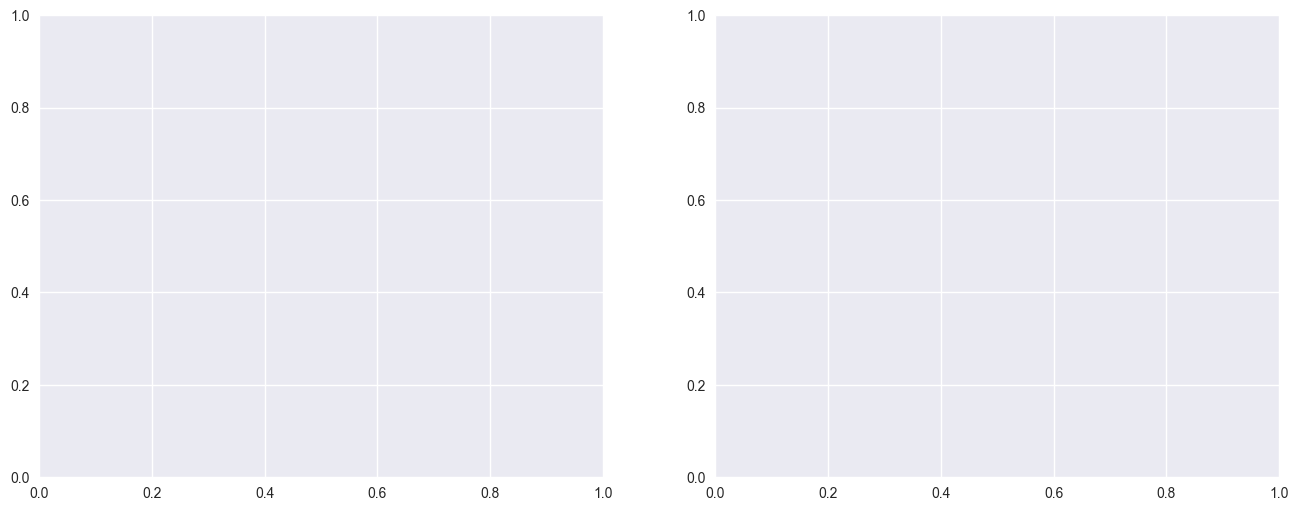

In [ ]:
# Visualisation 2: % de changement et slope comparés (sécurisé)
print('ℹ️ Visualisation des changements globaux...')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Construire viz_df de façon sûre en réutilisant mk_df si possible
if 'mk_df' in globals() and len(mk_df) > 0:
    src = mk_df.clone() if hasattr(mk_df, 'clone') else mk_df.copy()
    # si pct_change absent, on le calcule depuis df_annual
    if 'pct_change' not in src.columns:
        pct_calc = df_annual.groupby('ingredient_name').agg([
            pl.col('avg_rating').first().alias('first_rating'),
            pl.col('avg_rating').last().alias('last_rating'),
        ]).with_columns([
            (((pl.col('last_rating') - pl.col('first_rating')) / pl.when(pl.col('first_rating') != 0).then(pl.col('first_rating')).otherwise(pl.lit(None))) * 100).alias('pct_change')
        ])
        src = src.join(pct_calc.select(['ingredient_name', 'pct_change']), left_on='ingredient', right_on='ingredient_name', how='left')
    # garantir colonnes slope/p_value présentes
    if 'slope' not in src.columns:
        src = src.with_columns(pl.lit(0.0).alias('slope'))
    if 'p_value' not in src.columns:
        src = src.with_columns(pl.lit(1.0).alias('p_value'))
    viz_df = src.select(['ingredient', 'pct_change', 'slope', 'p_value']).with_columns([(pl.col('p_value') < 0.05).alias('significant')]).sort('pct_change', descending=True)
else:
    rows = []
    for ing in target_ingredients:
        ing_df = df_annual.filter(pl.col('ingredient_name') == ing).sort('year')
        if len(ing_df) >= 2:
            try:
                first = float(ing_df.select('avg_rating').to_series().to_list()[0])
                last = float(ing_df.select('avg_rating').to_series().to_list()[-1])
                pct = ((last - first) / first * 100) if first != 0 else 0.0
            except Exception:
                pct = 0.0
            rows.append({'ingredient': ing, 'pct_change': pct, 'slope': 0.0, 'p_value': 1.0, 'significant': False})
    viz_df = pl.DataFrame(rows).sort('pct_change', descending=True)

# Préparer vecteurs sûrs pour plotting
ingredients_sorted = viz_df.select('ingredient').to_series().to_list() if 'ingredient' in viz_df.columns else []
pct_changes = [float(x) if x is not None else 0.0 for x in viz_df.select('pct_change').to_series().to_list()] if 'pct_change' in viz_df.columns else [0.0]*len(ingredients_sorted)
significants = [bool(x) for x in viz_df.select('significant').to_series().to_list()] if 'significant' in viz_df.columns else [False]*len(ingredients_sorted)

# Ensure lengths match
n = len(ingredients_sorted)
if len(pct_changes) != n:
    pct_changes = (pct_changes + [0.0]*n)[:n]
if len(significants) != n:
    significants = (significants + [False]*n)[:n]

colors = ['#2ECC71' if p > 0 else '#E74C3C' for p in pct_changes]
alphas = [0.9 if sig else 0.5 for sig in significants]

bars1 = ax1.barh(ingredients_sorted, pct_changes, color=colors, alpha=alphas, edgecolor='black', linewidth=1)
for i, (bar, pct, sig) in enumerate(zip(bars1, pct_changes, significants)):
    width = bar.get_width()
    label = f'{pct:+.1f}%' + (' *' if sig else '')
    # Position label safely depending on sign
    offset = 0.5 if abs(width) < 1 else 0.5
    ax1.text(width + (offset if width > 0 else -offset), bar.get_y() + bar.get_height()/2.,
             label, ha='left' if width > 0 else 'right', va='center', fontweight='bold', fontsize=10)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax1.set_title('📊 % Changement Total (2000-2018)\n* = Statistiquement significatif (p<0.05)', fontsize=11, fontweight='bold')
ax1.set_xlabel('% de changement', fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

# Slope plot
slopes = [float(x) if x is not None else 0.0 for x in viz_df.select('slope').to_series().to_list()] if 'slope' in viz_df.columns else [0.0]*n
colors2 = ['#2ECC71' if s > 0 else '#E74C3C' for s in slopes]
alphas2 = [0.9 if sig else 0.5 for sig in significants]
bars2 = ax2.barh(ingredients_sorted, slopes, color=colors2, alpha=alphas2, edgecolor='black', linewidth=1)
for i, (bar, slope, sig) in enumerate(zip(bars2, slopes, significants)):
    width = bar.get_width()
    label = f'{slope:+.4f}' + (' *' if sig else '')
    # small offset for slope labels
    offset = 0.0005 if abs(width) < 0.01 else 0.0005
    ax2.text(width + (offset if width > 0 else -offset), bar.get_y() + bar.get_height()/2.,
             label, ha='left' if width > 0 else 'right', va='center', fontweight='bold', fontsize=10)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax2.set_title('Slope Annuel (Mann-Kendall)\n* = Statistiquement significatif', fontsize=11, fontweight='bold')
ax2.set_xlabel('Slope (pts/an)', fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print('✅ Visualisation des changements créée')